# A1 - Part 1: Dataset selection and preprocessing

In this notebook we prepare the dataset that will be used in the rest of the activity.

We will:

- Load the **Bike Sharing (hourly)** dataset (`hour.csv`).
- Explore the original variables and their meaning.
- Apply a log transform to the target (`cnt_log`).
- One-hot encode categorical variables and build an encoded dataset (`hour_encoded`).
- Prepare the final data for the models:
  - shuffle and sample 1500 patterns,
  - split into 80% train+validation and 20% test,
  - scale input features and the target variable.
- Save preproccesed data using joblib

The encoded dataframe and the preprocessed numpy arrays created here will be reused in:

- `A1_2_BP_From_Scratch_Experiments.ipynb`
- `A1_3_MLR_and_PyTorch_Comparison.ipynb`


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [2]:
hour = pd.read_csv('../data/hour.csv')

# Day dataframe Content

In [3]:
hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
hour.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


# Hour dataframe content

In [5]:
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Dataset format

- instant: unique record id
- dtday: date in YYYY-MM-DD format
- season: [1: spring, 2:summer, 3:fall, 4:winter]
- yr: [0: 2011, 1:2012]
- mnth: [1 to 12]
- hr: hour [0 to 23]
- weekday: day of the week [0..6] 
- holiday: [0: not holiday, 1:holiday]
- working day: [0: weeked or holiday 1: not weeked or holiday]
- weathersit :
  - Clear, Parly Cloudy
  - Mist, Cloudy
  - Light Snow, Light Rain, Thunderstorm 
  - Heavy Rain, Snow
- temp : Normalized temperature in Celsius (0.0 to 1.0). min=-8, max=+39 
- atemp: Normalized feeling temperature in Celsius (0.0 to 1.0). min=-16, max=+50
- hum: Normalized humidity (0.0 to 1.0) 
- windspeed: Normalized wind speed (0.0 to 1.0)
- casual: Casual users count
- registered: Registered users count
- cnt: Rental bikes count (casual + registered)

https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

In [6]:
# drop column we don't need
hour = hour.drop(columns=['instant', 'dteday'], errors='ignore')

# check distinct values
print(f'Season: {hour["season"].unique()}')
print(f'Year: {hour["yr"].unique()}')
print(f'Month: {hour["mnth"].unique()}')
print(f'Hour: {hour["hr"].unique()}')
print(f'Weekday: {hour["weekday"].unique()}')
print(f'Holiday: {hour["holiday"].unique()}')
print(f'Working Day: {hour["workingday"].unique()}')
print(f'Weathersit: {hour["weathersit"].unique()}')

Season: [1 2 3 4]
Year: [0 1]
Month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Hour: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Weekday: [6 0 1 2 3 4 5]
Holiday: [0 1]
Working Day: [0 1]
Weathersit: [1 2 3 4]


# Missing Values Analysis

In [7]:
print(hour.isnull().any())

season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool


# Outliers
From the graph below we can see that there is a large number of bike rentals with low count, but they represent valid data.

<Axes: xlabel='cnt', ylabel='Count'>

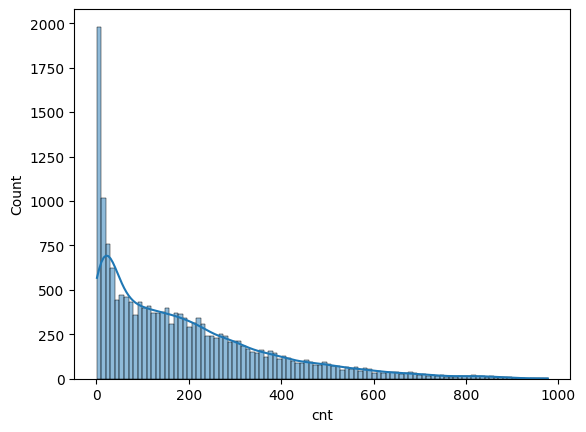

In [8]:
#sns.set(font_scale=1.0)
sns.histplot(hour["cnt"], kde=True, bins=100)

<Axes: xlabel='cnt_log', ylabel='Count'>

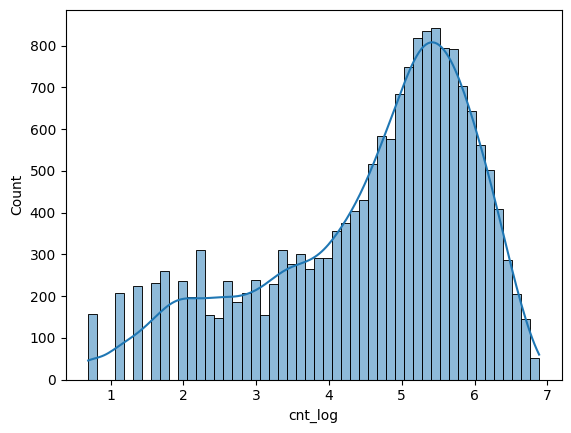

In [9]:
# Cnt is higly skewed. Log transform should improve model's accuracy
hour['cnt_log'] = np.log1p(hour['cnt'])
sns.histplot(hour['cnt_log'], kde=True, bins=50)

# Note: we will try predicting cnt_log, and will convert back to cnt using np.expm1(y_pred_log)

# Ensure categorical values are represented correctly
We one-hot encode categorical values and save the result into a new dataset
The intent is to prepare the csv for usage later in the pipeline


In [10]:
# One-hot encode categorical columns. 
categorical_cols = ['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit']

# categories have fixed values, known range
cat_map = {
    "season": [1, 2, 3, 4],      
    "yr": [0, 1],                       
    "mnth": list(range(1,13)),                              
    "hr": list(range(24)),                               
    "weekday": list(range(0,7)),      
    "weathersit": list(range(1,5))                       
}

# Format categories for OneHotEncoder (ie: list of category lists)
categories_for_encoder = [cat_map[c] for c in categorical_cols]

# Build encoder with explicit categories
# I don't set ignore error on purpose, as I want to surface them
encoder = OneHotEncoder(
    categories=categories_for_encoder,
    sparse_output=False
)

# Validate config (from given categories)
encoded = encoder.fit_transform(hour[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=hour.index)

# Assemble encoded dataset
hour_encoded = pd.concat([hour.drop(columns=categorical_cols), encoded_df], axis=1)

# Save the encoded dataset
hour_encoded.to_csv("../data/hours_encoded.csv", index=False) 

hour_encoded.head()

,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,cnt_log,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0,0.24,0.2879,0.81,0.0,3,13,16,2.833213,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0,0,0.22,0.2727,0.80,0.0,8,32,40,3.713572,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0,0,0.22,0.2727,0.80,0.0,5,27,32,3.496508,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0,0,0.24,0.2879,0.75,0.0,3,10,13,2.639057,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0,0,0.24,0.2879,0.75,0.0,0,1,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## Part 1.2 – Preparing the preprocessed dataset for the models

Now that we have the encoded dataset `hour_encoded`, we prepare the data in the exact
format that will be used by all the models (MLR, manual BP, PyTorch):

- select the regression target `cnt_log`,
- drop the original `cnt` column from the input features,
- randomly sample 1500 patterns,
- split into 80% train+validation and 20% test,
- apply feature scaling to inputs and target.

The resulting NumPy arrays will be used directly in the following notebooks of the assignment.


In [11]:

# Start from the encoded dataset
# Copy created in order to not modify the original reference
data = hour_encoded.copy()

print("Encoded dataset shape:", data.shape)
data.head()


Encoded dataset shape: (17379, 63)


,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,cnt_log,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0,0.24,0.2879,0.81,0.0,3,13,16,2.833213,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0,0,0.22,0.2727,0.80,0.0,8,32,40,3.713572,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0,0,0.22,0.2727,0.80,0.0,5,27,32,3.496508,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0,0,0.24,0.2879,0.75,0.0,3,10,13,2.639057,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0,0,0.24,0.2879,0.75,0.0,0,1,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [12]:

# Defining target and feature matrix

target_col = "cnt_log"

# We can safely drop the original 'cnt' if it is still present, because we are going to predict cnt_log instead.
if "cnt" in data.columns:
    data = data.drop(columns=["cnt"])

# Separate features (X) and target (y)
X_df = data.drop(columns=[target_col])
y = data[target_col].values

print("Feature matrix shape:", X_df.shape)
print("Target vector shape :", y.shape)
print("Number of features  :", X_df.shape[1])


Feature matrix shape: (17379, 61)
Target vector shape : (17379,)
Number of features  : 61


In [13]:

# Shuffle and sample 1500 patterns. We randomly sample 1500 rows to match the experiments

data_sampled = data.sample(n=1500, random_state=42).reset_index(drop=True)

X_df = data_sampled.drop(columns=[target_col])
y = data_sampled[target_col].values

print("After sampling 1500 rows:")
print("Feature matrix shape:", X_df.shape)
print("Target vector shape :", y.shape)


# Train / Test split (80% / 20%)

X_trainval_df, X_test_df, y_trainval, y_test = train_test_split(
    X_df, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("\nTrain+Val size:", X_trainval_df.shape[0])
print("Test size     :", X_test_df.shape[0])

# Convert to NumPy arrays
X_trainval = X_trainval_df.values
X_test = X_test_df.values

print("\nX_trainval shape:", X_trainval.shape)
print("X_test shape     :", X_test.shape)
print("y_trainval shape :", y_trainval.shape)
print("y_test shape     :", y_test.shape)


After sampling 1500 rows:
Feature matrix shape: (1500, 61)
Target vector shape : (1500,)

Train+Val size: 1200
Test size     : 300

X_trainval shape: (1200, 61)
X_test shape     : (300, 61)
y_trainval shape : (1200,)
y_test shape     : (300,)


In [14]:

# Feature scaling (StandardScaler for X). We scale the input features so that all models (MLR, manual BP, PyTorch) use the same normalized data.

x_scaler = StandardScaler()
X_trainval_np = x_scaler.fit_transform(X_trainval)
X_test_np     = x_scaler.transform(X_test)


# Target scaling (StandardScaler for y). It's also needed to scale the target value

y_scaler = StandardScaler()
y_trainval_scaled = y_scaler.fit_transform(y_trainval.reshape(-1, 1)).ravel()
y_test_scaled     = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

n_features = X_trainval_np.shape[1]
print("Number of input features:", n_features)


Number of input features: 61


In [15]:

# Save preprocessed data to disk

# These files will be reused in all other notebooks (BP, MLR, PyTorch)

np.save("../data/X_trainval_np.npy", X_trainval_np)
np.save("../data/X_test_np.npy",     X_test_np)

np.save("../data/y_trainval.npy",        y_trainval)
np.save("../data/y_test.npy",            y_test)
np.save("../data/y_trainval_scaled.npy", y_trainval_scaled)
np.save("../data/y_test_scaled.npy",     y_test_scaled)

# Save scalers with joblib so we can inverse-transform later
joblib.dump(x_scaler, "../data/x_scaler.joblib")
joblib.dump(y_scaler, "../data/y_scaler.joblib")

print("Saved preprocessed data and scalers:")
print("- X_trainval_np.npy, X_test_np.npy")
print("- y_trainval.npy, y_test.npy")
print("- y_trainval_scaled.npy, y_test_scaled.npy")
print("- x_scaler.joblib, y_scaler.joblib")


Saved preprocessed data and scalers:
- X_trainval_np.npy, X_test_np.npy
- y_trainval.npy, y_test.npy
- y_trainval_scaled.npy, y_test_scaled.npy
- x_scaler.joblib, y_scaler.joblib


## Summary of preprocessing

In this notebook we combined two main steps:

1. **Data understanding and encoding** (first part, by my teammate):
   - Loaded the original Bike Sharing hourly dataset (`hour.csv`).
   - Removed unnecessary columns.
   - Inspected categorical variables and their value ranges.
   - Checked for missing values.
   - Observed that `cnt` is highly skewed and created a log-transformed target `cnt_log`.
   - One-hot encoded categorical variables into a new dataframe `hour_encoded`.
   - Saved the encoded dataset into `hours_encoded.csv`.

2. **Preparing the final dataset for the models** (second part):
   - Started from `hour_encoded`.
   - Selected `cnt_log` as the regression target and dropped `cnt`.
   - Randomly sampled 1500 patterns for the experiments.
   - Split the data into:
     - 80% for training + validation (`X_trainval`, `y_trainval`),
     - 20% for test (`X_test`, `y_test`).
   - Applied **StandardScaler** to:
     - the input features (`X_trainval_np`, `X_test_np`),
     - the target values (`y_trainval_scaled`, `y_test_scaled`).

The following variables are now ready to be used in the next notebooks:

- `X_trainval_np`, `X_test_np`  → scaled input features
- `y_trainval`, `y_test`        → original target values
- `y_trainval_scaled`, `y_test_scaled` → scaled target values
- `x_scaler`, `y_scaler`        → fitted scalers (for inverse transformation)
- `n_features`                  → number of input features

These will be reused in:
- **A1_2_BP_From_Scratch_Experiments.ipynb** (manual backprop network)
- **A1_3_MLR_and_PyTorch_Comparison.ipynb** (MLR and PyTorch models).
